* Varför extenda gymmet om man inte ska göra RL. 
* Plotly för grafer. 
* Basecase: pip install lighgbm. Vad är fördelarna? 
* Side-by-side code comparison. 
* Comparing different predictors. 
* How does this relates to Gym. INtro to Gym. 
* Comparing differnt predictors. One that retrains one that doesn't. 
* What are the usecases this could support in the future. 

In [156]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from treen import load_example
import enflow as ef
import gymnasium as gym

### Step 1) Define the energy system 

In [157]:
df_data, df_scores = load_example('gefcom2014-wind')

windfarms = []
for name in df_data.columns.levels[0]:
    windfarms.append(ef.WindFarm(capacity=1, 
    name=name))

portfolio = ef.Portfolio(assets=windfarms)

In [158]:
df_data.head(3)

Site1                      \
                                            Power       U10      U100   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00  0.000000  2.124600  2.864280   
                    2012-01-01 02:00:00  0.054879  2.521695  3.344859   
                    2012-01-01 03:00:00  0.110234  2.672210  3.508448   

                                                                Site2  \
                                              V10      V100     Power   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00 -2.681966 -3.666076  0.596273   
                    2012-01-01 02:00:00 -1.796960 -2.464761  0.411180   
                    2012-01-01 03:00:00 -0.822516 -1.214093  0.167243   

                                                                       \
                                              U10      U100       V10   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00 -0.171642 -0.112594 -5.466031   
                    2012-01-01 02:00:00 -0.088859 -0.014100 -4.643205   
                    2012-01-01 03:00:00 -0.246014 -0.225238 -3.613395   

                                                   ... Site9            \
                                             V100  ... Power       U10   
ref_datetime        valid_datetime                 ...                   
2012-01-01 01:00:00 2012-01-01 01:00:00 -7.101347  ...   0.0  1.903254   
                    2012-01-01 02:00:00 -5.896778  ...   0.0  2.173296   
                    2012-01-01 03:00:00 -4.489369  ...   0.0  2.312744   

                                                                       \
                                             U100       V10      V100   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00  2.516723 -1.495002 -2.078063   
                    2012-01-01 02:00:00  2.837109 -0.643641 -1.006914   
                    2012-01-01 03:00:00  3.034096  0.136595 -0.015490   

                                           Site10                      \
                                            Power       U10      U100   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00  0.594361  1.655790  2.024257   
                    2012-01-01 02:00:00  0.569679  2.178609  2.623141   
                    2012-01-01 03:00:00  0.330539  2.228633  2.645217   

                                                             
                                              V10      V100  
ref_datetime        valid_datetime                           
2012-01-01 01:00:00 2012-01-01 01:00:00 -4.649593 -5.992232  
                    2012-01-01 02:00:00 -4.184944 -5.318086  
                    2012-01-01 03:00:00 -3.242442 -4.052232  

[3 rows x 50 columns]

In [159]:
dataset = ef.Dataset(name="gefcom2024",
                     description="Data provided by the organisers of HEFTCom2024. Participants are free to use additional external data.",
                     energy_system=portfolio,
                     data={"data_gefcom2014_wind": df_data, "scores_gefcom2014_wind": df_scores})

### Step 2) Define state, exogeneous and action spaces

In [160]:
state_space = ef.DataFrameSpace({asset.name: {
    'U10': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'V10': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'U100': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'V100': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'Power': gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
} for asset in portfolio.assets})

n_quantiles = 99

action_space = ef.DataFrameSpace({asset.name: {
    f"Quantile_forecast_{i+1}": gym.spaces.Box(low=0, high=1, shape=(1,)) for i in range(n_quantiles)
} for asset in portfolio.assets})


In [161]:
state_space.sample(n_rows=3)

Site1                                            Site10            \
      Power       U10      U100       V10      V100     Power       U10   
0  0.491100  0.921702 -0.393742 -0.802842 -1.771381  0.939613  1.031175   
1  0.984042  0.170070 -1.350338  0.549199  2.189217  0.848999  1.851952   
2  0.186601 -0.489856  1.817982 -0.808923  1.623291  0.568994 -0.382179   

                                 ...     Site8                                \
       U100       V10      V100  ...     Power       U10      U100       V10   
0  1.389287  0.478213 -0.782228  ...  0.342385  0.972314  0.286630  1.801902   
1  0.067349  0.596393  2.092906  ...  0.315616 -0.077295 -1.496346 -0.349467   
2  2.124102  0.049415  0.372227  ...  0.499184  0.889623 -0.072352 -1.026000   

                Site9                                          
       V100     Power       U10      U100       V10      V100  
0  2.180602  0.768831 -0.289004 -0.527458  0.114608  0.537489  
1  0.207624  0.861360  0.076303 -1.197976 -2.484889 -0.871462  
2 -1.559885  0.418410 -0.559943  0.036801  0.441020 -1.006819  

[3 rows x 50 columns]

In [162]:
action_space.sample(n_rows=3)

Site1                                            \
  Quantile_forecast_1 Quantile_forecast_10 Quantile_forecast_11   
0            0.764254             0.146048             0.334165   
1            0.737109             0.757149             0.934024   
2            0.921302             0.497813             0.252641   

                                                                  \
  Quantile_forecast_12 Quantile_forecast_13 Quantile_forecast_14   
0             0.681706             0.076537             0.295758   
1             0.402531             0.388512             0.380133   
2             0.044683             0.244832             0.443148   

                                                                  \
  Quantile_forecast_15 Quantile_forecast_16 Quantile_forecast_17   
0             0.510454             0.996416             0.066441   
1             0.709710             0.664633             0.155009   
2             0.063809             0.603101             0.872490   

                        ...                Site9                       \
  Quantile_forecast_18  ... Quantile_forecast_90 Quantile_forecast_91   
0             0.506760  ...             0.185489             0.623504   
1             0.934503  ...             0.930692             0.311561   
2             0.468328  ...             0.597735             0.976968   

                                                                  \
  Quantile_forecast_92 Quantile_forecast_93 Quantile_forecast_94   
0             0.481370             0.781395             0.155954   
1             0.132787             0.657177             0.734669   
2             0.793799             0.591426             0.617473   

                                                                  \
  Quantile_forecast_95 Quantile_forecast_96 Quantile_forecast_97   
0             0.172124             0.438283             0.805826   
1             0.081359             0.978171             0.776525   
2             0.043691             0.358021             0.411134   

                                             
  Quantile_forecast_98 Quantile_forecast_99  
0             0.826136             0.150139  
1             0.184910             0.415303  
2             0.112819             0.667172  

[3 rows x 990 columns]

### Step 3) Create environment

In [221]:
class GEFCom2014WindEnv(gym.Env):
    def __init__(self, dataset: ef.Dataset): 
        self.dataset = dataset
        self.data = dataset.data["data_gefcom2014_wind"]
        self.scores = dataset.data["scores_gefcom2014_wind"]
        self.input = ["U10", "V10", "U100", "V100"]
        self.target = ["Power"]
        self.state_space = state_space
        self.action_space = action_space
        self.idx_counter = 0

        self.train = [["2012-01-01 01:00:00", "2012-10-01 00:00:00"],
                      ["2012-10-01 01:00:00", "2012-11-01 00:00:00"],
                      ["2012-11-01 01:00:00", "2012-12-01 00:00:00"],
                      ["2012-12-01 01:00:00", "2013-01-01 00:00:00"],
                      ["2013-01-01 01:00:00", "2013-02-01 00:00:00"],
                      ["2013-02-01 01:00:00", "2013-03-01 00:00:00"],
                      ["2013-03-01 01:00:00", "2013-04-01 00:00:00"],
                      ["2013-04-01 01:00:00", "2013-05-01 00:00:00"],
                      ["2013-05-01 01:00:00", "2013-06-01 00:00:00"],
                      ["2013-06-01 01:00:00", "2013-07-01 00:00:00"],
                      ["2013-07-01 01:00:00", "2013-08-01 00:00:00"],
                      ["2013-08-01 01:00:00", "2013-09-01 00:00:00"],
                      ["2013-09-01 01:00:00", "2013-10-01 00:00:00"],
                      ["2013-10-01 01:00:00", "2013-11-01 00:00:00"],
                      ["2013-11-01 01:00:00", "2013-12-01 00:00:00"]]
        
        self.test = [["2012-10-01 01:00:00", "2012-11-01 00:00:00"],
                     ["2012-11-01 01:00:00", "2012-12-01 00:00:00"],
                     ["2012-12-01 01:00:00", "2013-01-01 00:00:00"],
                     ["2013-01-01 01:00:00", "2013-02-01 00:00:00"],
                     ["2013-02-01 01:00:00", "2013-03-01 00:00:00"],
                     ["2013-03-01 01:00:00", "2013-04-01 00:00:00"],
                     ["2013-04-01 01:00:00", "2013-05-01 00:00:00"],
                     ["2013-05-01 01:00:00", "2013-06-01 00:00:00"],
                     ["2013-06-01 01:00:00", "2013-07-01 00:00:00"],
                     ["2013-07-01 01:00:00", "2013-08-01 00:00:00"],
                     ["2013-08-01 01:00:00", "2013-09-01 00:00:00"],
                     ["2013-09-01 01:00:00", "2013-10-01 00:00:00"],
                     ["2013-10-01 01:00:00", "2013-11-01 00:00:00"],
                     ["2013-11-01 01:00:00", "2013-12-01 00:00:00"],
                     ["2013-12-01 01:00:00", "2014-01-01 00:00:00"]]

        self.n_steps = len(self.test)

    def reset(self, return_dataframe=False):
        self.idx_counter = 0
        initial_dataframe = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.train[self.idx_counter][0]) &
                                          (self.data.index.get_level_values('valid_datetime') <= self.train[self.idx_counter][1])]

        first_input = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter][0]) &
                                    (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter][1]),
                                     pd.IndexSlice[:, self.input]]

        return first_input, initial_dataframe

    def step(self, action=None):

        if self.idx_counter+1 < self.n_steps:
            next_input = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter+1][0]) &
                                       (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter+1][1]),
                                         pd.IndexSlice[:, self.input]] 

            next_target = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.train[self.idx_counter+1][0]) &
                                 (self.data.index.get_level_values('valid_datetime') <= self.train[self.idx_counter+1][1]),
                                  pd.IndexSlice[:, self.target]]

            done = False
            
            self.idx_counter += 1

            return next_input, next_target, done
    
        elif self.idx_counter+1 == self.n_steps:
            next_target = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter][0]) &
                                        (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter][1]),
                                  pd.IndexSlice[:, self.target]]
            
            done = True

            self.idx_counter += 1
            
            return None, next_target, done
        
    def plot_results(self, losses, drop_tasks=None, n_top_teams=None, xlim=None):
        df_scores = self.scores
        df_scores = df_scores.assign(**losses)
        df_scores = df_scores.drop(index=drop_tasks)
        df_scores.loc["Overall"] = df_scores.mean()
        teams = list(df_scores.drop(columns=losses.keys()).loc["Overall",:].sort_values().iloc[:n_top_teams].index.values)
        teams.extend(losses.keys())
        ax = df_scores.loc[::-1,teams].plot.barh(title="Pinball loss GEFCom20214")
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        if xlim: ax.set_xlim(0, xlim)

        return ax


### Step 4) Define the objective


In [222]:
from enflow.problems.objective import PinballLoss

obj = PinballLoss(quantiles=[0.1, 0.5, 0.9])

### Step 5) Create the model


In [250]:
import lightgbm as lgb
import pandas as pd

class LGBGEFCom2014Predictor(ef.Predictor):
    def __init__(self, name=None, quantiles=None):
        """
        Initialize the Predictor class.
        
        Args:
            quantiles (list): List of quantiles for which to create separate models.
                              Example: [0.1, 0.5, 0.9]
        """
        self.name = name
        self.models = {}  # Dictionary to hold models for each site and quantile
        self.quantiles = quantiles
        
    def train(self, features: pd.DataFrame, target: pd.DataFrame, **kwargs):
        """
        Train separate LightGBM models for each site and quantile.
        
        Args:
            features (pd.DataFrame): Multi-indexed dataframe where the top-level index corresponds to sites.
            target (pd.DataFrame): The target dataframe (y), also multi-indexed by site.
            kwargs: Additional parameters to pass to the LightGBMRegressor model.
        """
        # Get the list of unique sites from the multi-index (top level)
        sites = features.columns.get_level_values(0).unique()
        feature_names = features.columns.get_level_values(1).unique()
        with tqdm(total=len(sites)*len(self.quantiles), mininterval=0, desc=f"Training {self.name}") as pbar: 
            # Loop over each site
            for site in sites:
                # Extract the features and target for the current site
                site_features = features.xs(site, axis=1, level=0)
                site_target = target.xs(site, axis=1, level=0)

                # Loop over each quantile
                for quantile in self.quantiles:
                    # Initialize a LightGBM model for this quantile
                    params = {'objective': 'quantile', 'alpha': quantile, "verbose": -1}
                    params.update(kwargs)  # Add any additional LightGBM parameters
                    
                    model = lgb.LGBMRegressor(**params)
                    
                    # Train the model on the site's data
                    model.fit(site_features, site_target)
                    
                    # Store the trained model with a key (site, quantile)
                    self.models[(site, quantile)] = model
#                    pbar.update(1)

    def predict(self, features: pd.DataFrame):
        """
        Make predictions for a specific site and quantile using the trained model.
        
        Args:
            features (pd.DataFrame): The feature dataframe (X), multi-indexed by site.
            site (str): The site for which to make predictions.
            quantile (float): The quantile for which to make predictions.
        
        Returns:
            np.array: Predictions from the model.
        """

        # Create a nested dictionary to store predictions
        predictions = {}

        # Extract the features for the specific site
        sites = features.columns.get_level_values(0).unique()

        # Loop over each site and quantile
        for site in sites:
            # Extract the features for the current site
            site_features = features.xs(site, axis=1, level=0)

            # Initialize an inner dictionary for each site

            for quantile in self.quantiles:
                # Check if the model for the given site and quantile exists
                if (site, quantile) not in self.models:
                    raise ValueError(f"No trained model for site '{site}' and quantile '{quantile}'.")

                # Make predictions using the stored model
                model = self.models[(site, quantile)]
                site_predictions = model.predict(site_features)

                # Store the predictions under the quantile for the current site
                predictions[(site, f"quantile_{round(100*quantile)}")] = site_predictions

        # Convert the nested dictionary to a DataFrame with multi-index columns
        predictions = pd.DataFrame.from_dict(predictions)
        predictions.index = features.index
        
        return predictions


### Step 6) Run the sequential decision loop and evaluate performance

In [251]:
env = GEFCom2014WindEnv(dataset=dataset)
next_input, initial_df = env.reset()

In [252]:
initial_df.head(3)

Site1                      \
                                            Power       U10      U100   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00  0.000000  2.124600  2.864280   
                    2012-01-01 02:00:00  0.054879  2.521695  3.344859   
                    2012-01-01 03:00:00  0.110234  2.672210  3.508448   

                                                                Site2  \
                                              V10      V100     Power   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00 -2.681966 -3.666076  0.596273   
                    2012-01-01 02:00:00 -1.796960 -2.464761  0.411180   
                    2012-01-01 03:00:00 -0.822516 -1.214093  0.167243   

                                                                       \
                                              U10      U100       V10   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00 -0.171642 -0.112594 -5.466031   
                    2012-01-01 02:00:00 -0.088859 -0.014100 -4.643205   
                    2012-01-01 03:00:00 -0.246014 -0.225238 -3.613395   

                                                   ... Site9            \
                                             V100  ... Power       U10   
ref_datetime        valid_datetime                 ...                   
2012-01-01 01:00:00 2012-01-01 01:00:00 -7.101347  ...   0.0  1.903254   
                    2012-01-01 02:00:00 -5.896778  ...   0.0  2.173296   
                    2012-01-01 03:00:00 -4.489369  ...   0.0  2.312744   

                                                                       \
                                             U100       V10      V100   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00  2.516723 -1.495002 -2.078063   
                    2012-01-01 02:00:00  2.837109 -0.643641 -1.006914   
                    2012-01-01 03:00:00  3.034096  0.136595 -0.015490   

                                           Site10                      \
                                            Power       U10      U100   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00  0.594361  1.655790  2.024257   
                    2012-01-01 02:00:00  0.569679  2.178609  2.623141   
                    2012-01-01 03:00:00  0.330539  2.228633  2.645217   

                                                             
                                              V10      V100  
ref_datetime        valid_datetime                           
2012-01-01 01:00:00 2012-01-01 01:00:00 -4.649593 -5.992232  
                    2012-01-01 02:00:00 -4.184944 -5.318086  
                    2012-01-01 03:00:00 -3.242442 -4.052232  

[3 rows x 50 columns]

In [253]:
next_input.head(3)

Site1     Site2     Site3  \
                                              U10       U10       U10   
ref_datetime        valid_datetime                                      
2012-10-01 01:00:00 2012-10-01 01:00:00  2.685077 -3.031710  2.639064   
                    2012-10-01 02:00:00  2.720263 -2.836446  2.572558   
                    2012-10-01 03:00:00  2.709823 -2.826006  2.591891   

                                            Site4     Site5     Site6  \
                                              U10       U10       U10   
ref_datetime        valid_datetime                                      
2012-10-01 01:00:00 2012-10-01 01:00:00 -3.438091 -3.438091 -3.270280   
                    2012-10-01 02:00:00 -3.393625 -3.393625 -3.282267   
                    2012-10-01 03:00:00 -3.197588 -3.197588 -3.036350   

                                            Site7     Site8     Site9  \
                                              U10       U10       U10   
ref_datetime        valid_datetime                                      
2012-10-01 01:00:00 2012-10-01 01:00:00  3.397307  3.397307  3.028819   
                    2012-10-01 02:00:00  3.261975  3.261975  3.238002   
                    2012-10-01 03:00:00  3.143657  3.143657  3.329255   

                                           Site10  ...     Site1     Site2  \
                                              U10  ...      V100      V100   
ref_datetime        valid_datetime                 ...                       
2012-10-01 01:00:00 2012-10-01 01:00:00 -2.727794  ...  2.946774  0.944765   
                    2012-10-01 02:00:00 -2.815180  ...  3.011907  0.983955   
                    2012-10-01 03:00:00 -2.673275  ...  3.288446  1.420566   

                                            Site3     Site4     Site5  \
                                             V100      V100      V100   
ref_datetime        valid_datetime                                      
2012-10-01 01:00:00 2012-10-01 01:00:00  4.421648  0.995546  0.995546   
                    2012-10-01 02:00:00  4.514931  1.155619  1.155619   
                    2012-10-01 03:00:00  5.042618  1.076687  1.076687   

                                            Site6     Site7     Site8  \
                                             V100      V100      V100   
ref_datetime        valid_datetime                                      
2012-10-01 01:00:00 2012-10-01 01:00:00  1.405111  1.960397  1.960397   
                    2012-10-01 02:00:00  1.433262  1.763894  1.763894   
                    2012-10-01 03:00:00  1.584502  2.046505  2.046505   

                                            Site9    Site10  
                                             V100      V100  
ref_datetime        valid_datetime                           
2012-10-01 01:00:00 2012-10-01 01:00:00  3.258639  1.214128  
                    2012-10-01 02:00:00  4.140141  1.460308  
                    2012-10-01 03:00:00  4.557433  1.870977  

[3 rows x 40 columns]

In [254]:
predictor1 = LGBGEFCom2014Predictor(name="predictor1", quantiles=[0.1, 0.5, 0.9])
predictor1.train(features=training_input, target=training_target)



Training predictor1:   0%|          | 0/30 [00:05<?, ?it/s]


In [240]:
training_input = initial_df.loc[:,(slice(None), env.input)]
training_target = initial_df.loc[:,(slice(None), env.target)]

predictor1 = LGBGEFCom2014Predictor(name="predictor1", quantiles=np.arange(0.01, 1, 0.01))
predictor1.train(features=training_input, target=training_target)

predictor2 = LGBGEFCom2014Predictor(name="predictor2", quantiles=np.arange(0.01, 1, 0.01))
predictor2.train(features=training_input, target=training_target)

KeyboardInterrupt: 

In [228]:
# Make this on loop and train every time. 
losses = {predictor1.name: [], predictor2.name: []}
for i in range(env.n_steps):
    training_input = pd.concat([training_input, next_input])
    prediction1 = predictor1.predict(features=next_input)
    prediction2 = predictor2.predict(features=next_input)

    next_input, next_target, done = env.step()

    loss1 = obj.calculate(next_target, prediction1)
    loss2 = obj.calculate(next_target, prediction2)

    losses[predictor1.name].append(loss1)
    losses[predictor2.name].append(loss2)

    training_target = pd.concat([training_target, next_target])
    predictor2.train(features=training_input, target=training_target)

    print(f"{predictor1.name} {obj.name} for step {i+1}: {loss1}")
    print(f"{predictor2.name} {obj.name} for step {i+1}: {loss2}")

Training predictor2: 100%|██████████| 30/30 [00:04<00:00,  6.41it/s]


predictor1 PinballLoss for step 1: 0.037202735614596916
predictor2 PinballLoss for step 1: 0.037202735614596916


Training predictor2: 100%|██████████| 30/30 [00:04<00:00,  6.28it/s]


predictor1 PinballLoss for step 2: 0.04028743964443124
predictor2 PinballLoss for step 2: 0.03979295196866547


Training predictor2: 100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


predictor1 PinballLoss for step 3: 0.03923966592211218
predictor2 PinballLoss for step 3: 0.03836790617464987


Training predictor2: 100%|██████████| 30/30 [00:05<00:00,  5.49it/s]


predictor1 PinballLoss for step 4: 0.037146705705806284
predictor2 PinballLoss for step 4: 0.03584324966818392


Training predictor2: 100%|██████████| 30/30 [00:04<00:00,  7.00it/s]


predictor1 PinballLoss for step 5: 0.04169524410496957
predictor2 PinballLoss for step 5: 0.04003572462316491


Training predictor2: 100%|██████████| 30/30 [00:04<00:00,  6.91it/s]


predictor1 PinballLoss for step 6: 0.0394246802170204
predictor2 PinballLoss for step 6: 0.038295592988288184


Training predictor2: 100%|██████████| 30/30 [00:04<00:00,  6.84it/s]


predictor1 PinballLoss for step 7: 0.03180254089847141
predictor2 PinballLoss for step 7: 0.031049985720455853


Training predictor2: 100%|██████████| 30/30 [00:04<00:00,  7.05it/s]


predictor1 PinballLoss for step 8: 0.03997756397532627
predictor2 PinballLoss for step 8: 0.03958478909871211


Training predictor2: 100%|██████████| 30/30 [00:04<00:00,  6.31it/s]


predictor1 PinballLoss for step 9: 0.03245118000772528
predictor2 PinballLoss for step 9: 0.031755844980307535


Training predictor2: 100%|██████████| 30/30 [00:05<00:00,  5.73it/s]


predictor1 PinballLoss for step 10: 0.036856532007231754
predictor2 PinballLoss for step 10: 0.03585119050927904


Training predictor2: 100%|██████████| 30/30 [00:06<00:00,  4.98it/s]


predictor1 PinballLoss for step 11: 0.0388909546165719
predictor2 PinballLoss for step 11: 0.038603367290370456


Training predictor2: 100%|██████████| 30/30 [00:06<00:00,  4.93it/s]


predictor1 PinballLoss for step 12: 0.040784263123730395
predictor2 PinballLoss for step 12: 0.03908483884933855


Training predictor2: 100%|██████████| 30/30 [00:05<00:00,  5.60it/s]


predictor1 PinballLoss for step 13: 0.042578590719846446
predictor2 PinballLoss for step 13: 0.04097303589673672


Training predictor2: 100%|██████████| 30/30 [00:05<00:00,  5.02it/s]


predictor1 PinballLoss for step 14: 0.041318516324705255
predictor2 PinballLoss for step 14: 0.039639776321646114


Training predictor2: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]

predictor1 PinballLoss for step 15: 0.04023710128398869
predictor2 PinballLoss for step 15: 0.03796297895861446


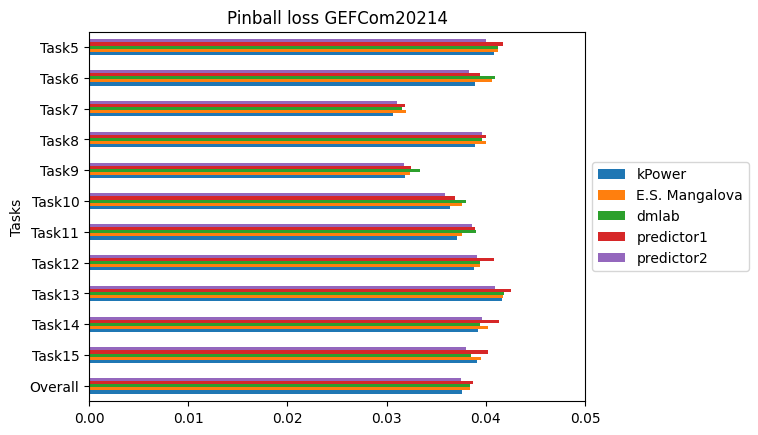

In [234]:
env.plot_results(losses, 
                 drop_tasks=["Task1", "Task2", "Task3", "Task4"], 
                 n_top_teams=3,
                 xlim=0.05);